In [1]:
import torch
import numpy as np
from PIL import Image
import torchvision


class Dataset(torch.utils.data.Dataset):
    def __init__(self, part):
        self.part = part
        self.data = np.loadtxt(fname='data/pika/%s.csv' % part, delimiter=',')

        #数据增强模块,这里不需要什么太高级的变化
        self.transforms = torchvision.transforms.ToTensor()

    def __getitem__(self, idx):
        x = Image.open('data/pika/%s/%s.jpg' % (self.part, idx))
        x = self.transforms(x)

        y = {
            'labels': torch.LongTensor([1]),
            'boxes': torch.LongTensor([self.data[idx] * 256])
        }

        return x, y

    def __len__(self):
        return len(self.data)


def collate_fn(data):
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    return x, y


loader = torch.utils.data.DataLoader(dataset=Dataset(part='train'),
                                     batch_size=8,
                                     shuffle=True,
                                     drop_last=True,
                                     collate_fn=collate_fn)

for i, (x, y) in enumerate(loader):
    break

print(len(loader), type(x), type(y), len(x), len(y))

x[0], x[0].dtype, x[0].shape, y[0]

116 <class 'list'> <class 'list'> 8 8


/root/anaconda3/envs/tt/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/torch/csrc/utils/tensor_new.cpp:201.)


(tensor([[[0.4941, 0.4941, 0.4941,  ..., 0.5569, 0.5608, 0.5490],
          [0.4941, 0.4941, 0.4941,  ..., 0.5569, 0.5569, 0.5373],
          [0.4980, 0.4980, 0.4980,  ..., 0.5647, 0.5608, 0.5373],
          ...,
          [0.2078, 0.2078, 0.2039,  ..., 0.3843, 0.3608, 0.3490],
          [0.2039, 0.2039, 0.2078,  ..., 0.3608, 0.3412, 0.3137],
          [0.1961, 0.2000, 0.2078,  ..., 0.4157, 0.3451, 0.3725]],
 
         [[0.7451, 0.7451, 0.7451,  ..., 0.7647, 0.7686, 0.7804],
          [0.7451, 0.7451, 0.7451,  ..., 0.7647, 0.7686, 0.7804],
          [0.7490, 0.7490, 0.7490,  ..., 0.7686, 0.7725, 0.7843],
          ...,
          [0.2078, 0.2078, 0.2039,  ..., 0.4157, 0.4118, 0.4196],
          [0.2039, 0.2039, 0.2078,  ..., 0.3961, 0.4000, 0.3922],
          [0.1961, 0.2000, 0.2078,  ..., 0.4588, 0.4157, 0.4588]],
 
         [[0.9176, 0.9176, 0.9176,  ..., 0.9686, 0.9255, 0.8980],
          [0.9176, 0.9176, 0.9176,  ..., 0.9686, 0.9412, 0.9255],
          [0.9216, 0.9216, 0.9216,  ...,

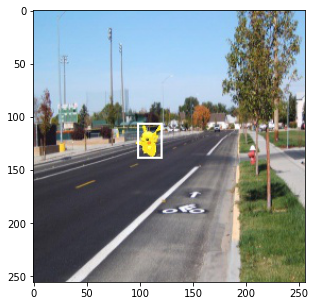

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import PIL.Image
import PIL.ImageDraw


#画出anchor
def show(x, y, out):
    x = x.detach().numpy() * 255.0
    x = x.astype(np.uint8)

    #(3, 256, 256) -> (256, 256, 3)
    x = x.transpose((1, 0, 2))
    x = x.transpose((0, 2, 1))

    y = y.detach().tolist()

    image = PIL.Image.fromarray(x)
    draw = PIL.ImageDraw.Draw(image)

    draw.rectangle(xy=y, outline='white', width=2)

    if out and len(out['scores']) > 0:
        idx = out['scores'].argmax().item()
        draw.rectangle(xy=out['boxes'][idx].tolist(), outline='black', width=2)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()


show(x[0], y[0]['boxes'][0], None)

In [3]:
#创建模型
model = torchvision.models.detection.ssd300_vgg16(pretrained=False,
                                                  progress=True,
                                                  num_classes=2,
                                                  pretrained_backbone=True,
                                                  trainable_backbone_layers=5)

print(sum(p.numel() for p in model.parameters()) / 10000)

model(x, y)

2374.5908


/root/anaconda3/envs/tt/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'bbox_regression': tensor(6.7195, grad_fn=<DivBackward0>),
 'classification': tensor(47.1057, grad_fn=<DivBackward0>)}

In [4]:
def train():
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    for epoch in range(1):
        for i, (x, y) in enumerate(loader):
            outs = model(x, y)
            loss = outs['bbox_regression'] + outs['classification']
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % 10 == 0:
                print(epoch, i, loss.item())

        torch.save(model, './models/使用torchvision实现.model')


#train()

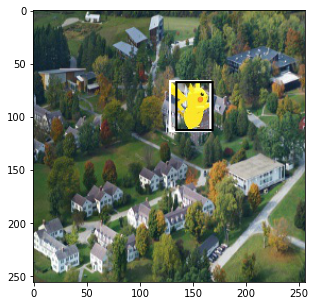

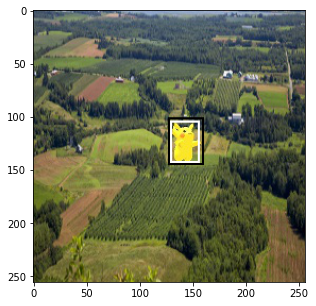

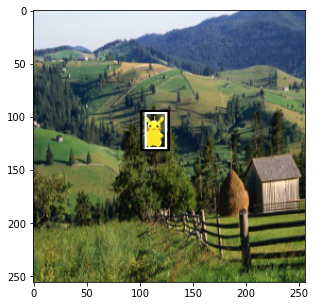

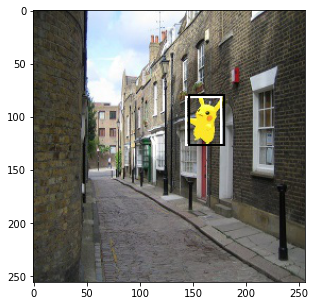

In [5]:
def test():
    loader_test = torch.utils.data.DataLoader(dataset=Dataset(part='test'),
                                              batch_size=4,
                                              shuffle=True,
                                              drop_last=True,
                                              collate_fn=collate_fn)

    for i, (x, y) in enumerate(loader_test):
        break

    model_load = torch.load('./models/使用torchvision实现.model')
    model_load.eval()

    with torch.no_grad():
        outs = model_load(x)

    for i in range(4):
        show(x[i], y[i]['boxes'][0], outs[i])


test()